In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
from ows import ows
from ows import fouriertransform as mathft
from astropy.io import fits
from astropy.visualization import SqrtStretch
import numpy as np


In [2]:
from PIL import Image

# Assemble dataset

In [ ]:
n = 9999

# train_DwDx = np.zeros((n,128,128))
# train_DwDy = np.zeros((n,128,128))
train_Dw = np.zeros((n,128,128,2))
#train_Dw = np.zeros((n,128,128))
train_lightfield = np.zeros((n,128,128))
train_psf = np.zeros((n,128,128))
print(train_Dw.shape)
filename0 = "data/DwDx_"
filename1 = "data/DwDy_"
filename2 = "data/lightfield_"
filename3 = "data/psf_"

status = 0
for i in range(0,n):
    train_Dw[i,:,:,0] = ows.pixel_adder(np.array(fits.getdata(filename0+str(i)+".fits")), scale_factor = [8,8], final_shape = None)/np.pi
    #train_Dw[i,:,:,1] = np.array(fits.getdata(filename0+str(i)+".fits"))
    train_Dw[i,:,:,1] = ows.pixel_adder(np.array(fits.getdata(filename1+str(i)+".fits")), scale_factor = [8,8], final_shape = None)/np.pi
    #train_Dw[i,:,:,1] = np.array(fits.getdata(filename1+str(i)+".fits"))

    # train_lightfield[:,:,i] = ows.pixel_adder(np.array(fits.getdata(filename2+str(i)+".fits"),[1/8,1/8])
    train_lightfield[i,:,:] = np.array(fits.getdata(filename2+str(i)+".fits"))
    # train_psf[:,:,i] = ows.pixel_adder(np.array(fits.getdata(filename3+str(i)+".fits")),[1/8,1/8])
    train_psf[i,:,:] = ows.normalize(np.array(fits.getdata(filename3+str(i)+".fits")))
    if 100*i//n == status*10:
        print('Loading training set: ',status*10,'% done')
        status += 1
print('Loading training set: ',100,'% done')
#np.savez("data/train_DwDx.npz", train_DwDy)
#np.savez("data/train_DwDy.npz", train_DwDy)
np.savez("data/train_Dw.npz", train_Dw)
np.savez("data/train_lightfield.npz", train_lightfield)
np.savez("data/train_psf.npz", train_psf)


(9999, 128, 128, 2)
Loading training set:  0 % done
Loading training set:  10 % done
Loading training set:  20 % done
Loading training set:  30 % done
Loading training set:  40 % done
Loading training set:  50 % done
Loading training set:  60 % done
Loading training set:  70 % done
Loading training set:  80 % done
Loading training set:  90 % done
Loading training set:  100 % done


In [2]:
# del train_DwDx
# del train_DwDy
#del train_lightfield
rng = np.random.default_rng(seed=None)
n =9999

(5999, 128, 128, 2)


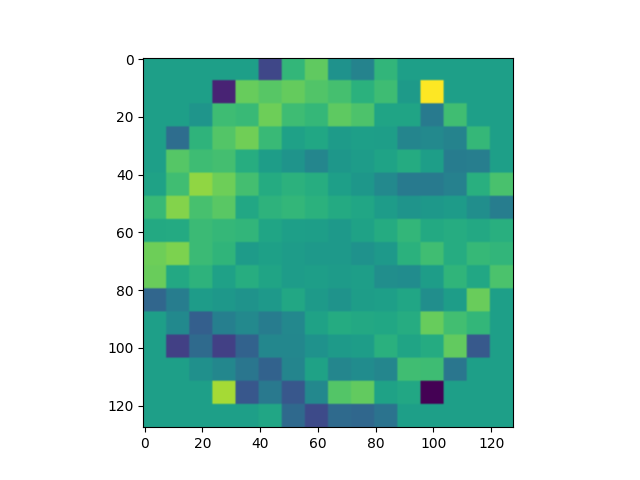

(4000, 128, 128, 2) (5999, 128, 128, 2)
(4000, 128, 128) (5999, 128, 128)


In [3]:
# Training set
rng = np.random.default_rng(n)
temp = np.load("data/train_Dw.npz")["arr_0"]
n = temp.shape[0]
k = 0.6 
train_id = np.zeros(n,np.bool)

train_id[rng.choice(n,int(k*n),replace=False)] = True


x_train = temp[train_id,:,:,:]
x_val = temp[~train_id,:,:,:]
# y_train = temp[train_id,:,:]
# y_val = temp[~train_id,:,:]


temp = np.load("data/train_psf.npz")["arr_0"]

y_train = temp[train_id,:,:]
y_val = temp[~train_id,:,:]

print(x_train.shape)

plt.close(1)
plt.figure(1)
plt.imshow(x_train[4,:,:,1])
plt.show()

print(x_val.shape,x_train.shape)
print(y_val.shape,y_train.shape)


# Unet

In [4]:
import unet
model = unet.build_unet(input_shape=(128,128,2), n_channels_out=1)

#model.summary()

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau 
weight_path="{}_weights.best.weights.h5".format('cxr_reg') 
 
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,  
                             save_best_only=True, mode='min', save_weights_only = True) 
 
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=3, 
                                   verbose=1, mode='min', epsilon=0.05, cooldown=2, min_lr=1e-6) 
 
early = EarlyStopping(monitor="val_loss",  mode="min", patience=15) # probably needs to be more patient, but kaggle time is limited 
callbacks_list = [checkpoint, early, reduceLROnPlat]

from IPython.display import clear_output 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.optimizers import SGD 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_curve, auc 
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss=[unet.mse_loss], metrics = [unet.dice_coef, 'binary_accuracy',"AUC" ]) 
#images, mask = images/255, (mask>127).astype(np.float32) 
                                                            
train_vol = x_train

validation_vol = x_val
train_seg = y_train
validation_seg = y_val

print(train_seg.shape)

(5999, 128, 128)


In [6]:
loss_history = model.fit(x = train_vol,y = train_seg,batch_size = 8,epochs = 100,validation_data =(validation_vol,validation_seg) , callbacks=callbacks_list)


Epoch 1/100
 22/750 ━━━━━━━━━━━━━━━━━━━━ 17:59 1s/step - AUC: 0.5206 - binary_accuracy: 6.1641e-05 - dice_coef: 0.0103 - loss: 0.5868

KeyboardInterrupt: 

# Training results

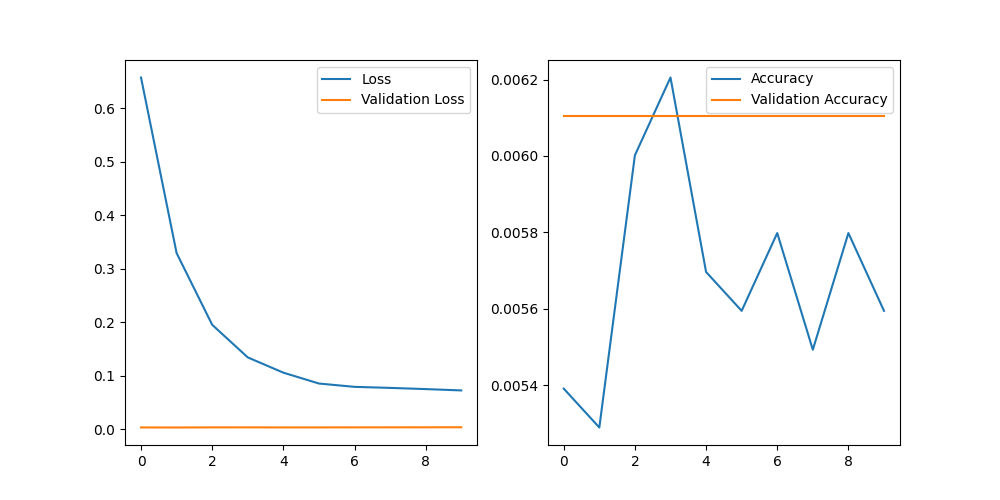

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',label = 'Validation Accuracy')
ax2.legend()

# Inference

(1, 128, 128, 1)


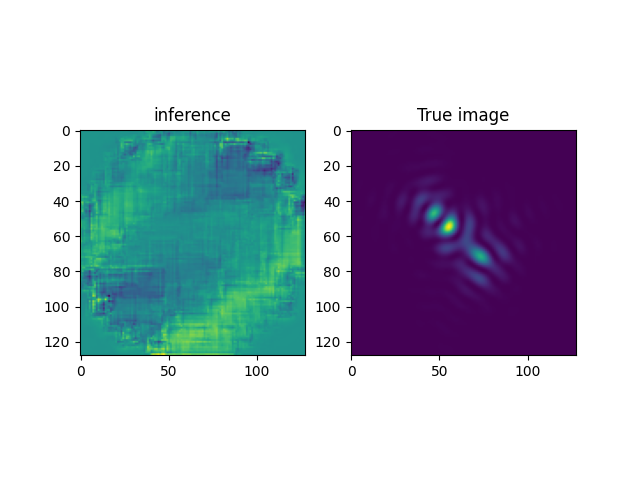

In [ ]:
DwDx = ows.pixel_adder(np.array(fits.getdata("data/DwDx_9999.fits")), scale_factor = [8,8], final_shape = None)
DwDy = ows.pixel_adder(np.array(fits.getdata("data/DwDy_9999.fits")), scale_factor = [8,8], final_shape = None)
psf = np.array(fits.getdata("data/psf_9999.fits"))
#Dw = (DwDx**2 + DwDx**2)**(1/2)
Dw = np.zeros((128,128,2))

Dw[:,:,0] = DwDx
Dw[:,:,1] = DwDy

im = np.expand_dims(Dw, axis=0)

predictions = model(im)
print(predictions.shape)


plt.close(2)
plt.figure(2)
plt.subplot(1,2,1)
plt.imshow(predictions[0,:,:])
plt.title("inference")
plt.subplot(1,2,2)
plt.imshow(psf[:,:])
plt.title("True image")
plt.show()
